# Graphics for the Result section

This notebook will produce the graphics in the results section of the thesis. Namely the comparison of the four experiment settings: Baseline, DataShift, SinGAN and Oversampling. As they require some more.

Following steps:
* unify the prediction function: Not only image name and predicted lesion, but also the scores for each lesion! DONE!
* Then just use those predicted csv for the processing, as all statistics can easily be derived from them.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

TRAINING_PATH = "./data/ISIC2018/ISIC2018_Task3_Training_Input/"
label_path = f"{TRAINING_PATH}metadata.csv"
PREDICTION_PATH = "./predictions/"
df_all = pd.read_csv(label_path)

In [19]:
experiments = ["01DataShift00Compare41","01DataShift02Compare41","01DataShift04Compare41","01DataShift01Threshold41","01DataShift03Threshold41","01DataShift05Threshold41","02SinGAN00Augmented","02SinGAN01Augmented","02SinGAN02Augmented","02SinGAN03Oversampled","02SinGAN04Oversampled","02SinGAN05Oversampled"]
Controls = experiments[0:3]
Shifts = experiments[3:6]
SinGAN = experiments[6:9]
Oversampled = experiments[9:]
Setups = [Controls,Shifts,SinGAN,Oversampled]

## The overall cat_acc

In [11]:
from sklearn.metrics import balanced_accuracy_score as cat_acc

In [24]:
Cat_Accs = np.zeros((4,3)) # 4 experiment settings x 3 repetitions 
for i in range(len(Setups)):
    setup = Setups[i]
    for j in range(len(setup)):
        exp_name = setup[j]
        df_pred = pd.read_csv(f"{PREDICTION_PATH}predictions_{exp_name}.csv")
        df_merged = pd.merge(df_all, df_pred, left_on='image', right_on='image')
        # cat_acc
        y_pred = df_merged["predicted_lesion"].values
        y_true = df_merged["lesion"].values
        Cat_Accs[i,j] = cat_acc(y_true,y_pred)
stats_acc = np.zeros((4,2)) # 4 settings times mean, std
stats_acc[:,0] = np.mean(Cat_Accs,axis=1)
stats_acc[:,1] = np.std(Cat_Accs,axis=1)
stats_acc 

array([[0.69128714, 0.01189252],
       [0.60398171, 0.00790987],
       [0.6139695 , 0.0076085 ],
       [0.62403736, 0.01324302]])

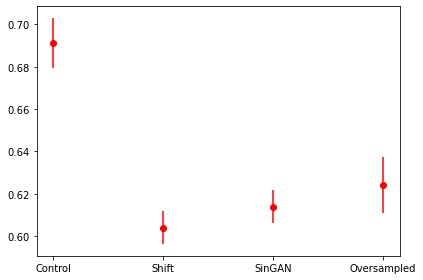

In [45]:
#plt.plot(["Control","Shift","SinGAN","Oversampled"],stats_acc[:,0],"o")
plt.errorbar(["Control","Shift","SinGAN","Oversampled"], stats_acc[:,0], yerr=stats_acc[:,1], fmt="o",color="r")
plt.tight_layout()
plt.show()

In [224]:
np.round(stats_acc,3)

array([[0.691, 0.012],
       [0.604, 0.008],
       [0.614, 0.008],
       [0.624, 0.013]])

This is something to work with, but it still needs to be beautified or used as a table.
A table takes less space.

## Cat_ACC per skin type in the Control experiment


In [ ]:
Cat_Accs_skin_tone = np.zeros((7,3)) # skin types (6+undef) x experiments
ITA_thresholds = [180,55,41,28,19,10,-180]
for j in range(len(Controls)):
    exp_name = Controls[j]
    df_pred = pd.read_csv(f"{PREDICTION_PATH}predictions_{exp_name}.csv")
    df_merged = pd.merge(df_all, df_pred, left_on='image', right_on='image')
    # cat_acc
    for i in range(len(ITA_thresholds)-1):
        df_filtered = df_merged[df_merged['estimated_ita'] > ITA_thresholds[i+1]]
        df_filtered = df_filtered[df_filtered['estimated_ita'] <= ITA_thresholds[i]]
        y_pred = df_filtered["predicted_lesion"].values
        y_true = df_filtered["lesion"].values
        Cat_Accs_skin_tone[i,j] = cat_acc(y_true,y_pred)
    df_nan = df_merged[df_merged.isna()]
    y_pred = df_filtered["predicted_lesion"].values
    y_true = df_filtered["lesion"].values
    Cat_Accs_skin_tone[6,j] = cat_acc(y_true,y_pred)
    

In [51]:
Cat_Accs_skin_tone

array([[0.675     , 0.68095238, 0.88157895],
       [0.67746879, 0.69803777, 0.69498565],
       [0.64275675, 0.6352828 , 0.70755446],
       [0.69444444, 0.3       , 0.625     ],
       [1.        , 0.5       , 0.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ]])

In [52]:
stats_acc_skin_tone = np.zeros((7,2)) # 4 settings times mean, std
stats_acc_skin_tone[:,0] = np.mean(Cat_Accs_skin_tone,axis=1)
stats_acc_skin_tone[:,1] = np.std(Cat_Accs_skin_tone,axis=1)
stats_acc_skin_tone 

array([[0.74584378, 0.09601002],
       [0.69016407, 0.00906298],
       [0.66186467, 0.03245132],
       [0.53981481, 0.17192826],
       [0.5       , 0.40824829],
       [1.        , 0.        ],
       [1.        , 0.        ]])

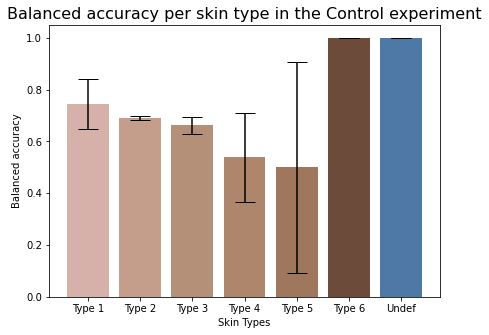

In [223]:
skin_colors = ["#d5b1a9","#c59d8b","#b59079","#ae866c","#9f775c","#6d4b3a","#4e79a7"]
plt.figure(figsize=(7,5))
plt.bar(["Type 1","Type 2","Type 3","Type 4","Type 5","Type 6","Undef"], stats_acc_skin_tone[:,0],color=skin_colors)
plt.errorbar(["Type 1","Type 2","Type 3","Type 4","Type 5","Type 6","Undef"], stats_acc_skin_tone[:,0], yerr=stats_acc_skin_tone[:,1], fmt="o",markersize=0,color="k",capsize=10)
#plt.tight_layout()
plt.xlabel("Skin Types")
plt.ylabel("Balanced accuracy")
plt.title("Balanced accuracy per skin type in the Control experiment",fontsize=16)
plt.savefig("Acc_skin.png")
plt.show()

## OvR ROC
This section aims to asses the averaged OvR ROC and their AUC for all four experiments. The average is easily obtained by concatenating the predictions for each iteration.

In [89]:
lesions = ["AKIEC","BCC","BKL","DF","MEL","NV","VASC"]
from sklearn.metrics import roc_curve,auc

In [91]:
lesion = lesions[0]
TPR = [] # list of list of arrays: lesions (setup (arrays) )
FPR = []
AUC = []
# 
for k in range(len(lesions)):
    lesion = lesions[k]
    fpr_lesion = []
    tpr_lesion = []
    auc_lesion = []
    for i in range(len(Setups)):
        setup = Setups[i]
        y_score = np.zeros(0) # empty arrays of size 0 and shape (0,)
        y_true = np.zeros(0)
        for j in range(len(setup)):
            exp_name = setup[j]
            df_pred = pd.read_csv(f"{PREDICTION_PATH}predictions_{exp_name}.csv")
            df_merged = pd.merge(df_all, df_pred, left_on='image', right_on='image')
            # OvR 
            # here the lesions for loop
            y_score = np.append(y_score,df_merged[lesion].values)
            y_true = np.append(y_true,((df_merged["lesion"]==lesion)*1).values)
        fpr,tpr,thr = roc_curve(y_true,y_score)
        fpr_lesion.append(fpr)
        tpr_lesion.append(tpr)
        auc_lesion.append(auc(fpr,tpr))
    TPR.append(tpr_lesion)
    FPR.append(fpr_lesion)
    AUC.append(auc_lesion)

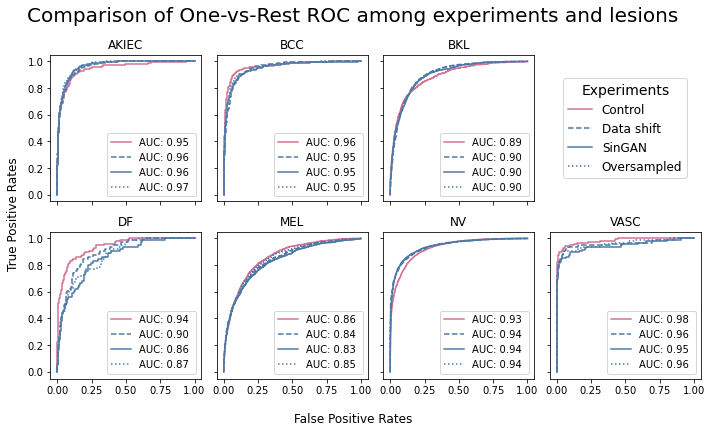

In [226]:
import matplotlib.lines as mpatches
Setup_names = ["Control","Data shift","SinGAN","Oversampled"]
Colors = ["#d37295","#4e79a7","#4e79a7","#4e79a7"] # same as in tableau!
Line_type = ["-","--","-",":"]
fig,ax = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,6),tight_layout=False)
bottom_right_ax = ax[0][3]
bottom_right_ax.set_axis_off() 
plt.suptitle("Comparison of One-vs-Rest ROC among experiments and lesions",fontsize=20)
#plt.xlabel("False Positive Rates")
#plt.ylabel("True Positive Rates")
ax = ax.ravel()
for k in range(len(lesions)):
    k_star = k
    if k >2:
        k_star = k +1
    tpr_lesion = TPRs[k]
    fpr_lesion = FPRs[k]
    for i in range(len(fpr_lesion)):

        ax[k_star].plot(fpr_lesion[i],tpr_lesion[i],color=Colors[i],ls=Line_type[i],label="AUC: {:.2f} ".format(AUC[k][i]))
    ax[k_star].legend()
    ax[k_star].set(title=lesions[k])
fig.supxlabel("False Positive Rates")
fig.supylabel("True Positive Rates")

patch0 = mpatches.Line2D([0],[0],color=Colors[0], label=Setup_names[0],ls=Line_type[0])
patch1 = mpatches.Line2D([0],[0],color=Colors[1], label=Setup_names[1],ls=Line_type[1])
patch2 = mpatches.Line2D([0],[0],color=Colors[2], label=Setup_names[2],ls=Line_type[2])
patch3 = mpatches.Line2D([0],[0],color=Colors[3], label=Setup_names[3],ls=Line_type[3])

# Add legend to bottom-right ax
bottom_right_ax.legend(handles=[patch0, patch1 ,patch2 , patch3], loc='center',title="Experiments",fontsize=12,title_fontsize=14)

#bottom_right_ax.legend(Setup_names,title="Experiments")
fig.savefig("OVR_ROC.png")
plt.show()
